# Udacity Self-Driving Car Engineer Nanodegree Program
## Vehicle Detection Project
The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.
---

### Import Packages

In [1]:
from skimage.feature import hog
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
# import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pandas as pd
import pickle
import cv2
import glob
import time
import random
import csv

%matplotlib inline

print('>> Done!')

>> Done!


### Helper Functions
The following code cell includes some helper functions which has been used in the rest of implementation.

In [9]:
def plot_sample_data(files, titles, v_plot_count=1, fig_size=(8, 8), _axis = 'off', path=''):
    h_plot_count = int(np.ceil(len(files)/v_plot_count))
    fig, axs = plt.subplots(v_plot_count, h_plot_count, figsize=fig_size)
    fig.subplots_adjust(hspace = .2, wspace=.001)
    axs = axs.ravel()
    for i in np.arange(len(files)):
        img = read_img(path+files[i])
        axs[i].axis(_axis)
        axs[i].set_title(titles[i], fontsize=10)
        axs[i].imshow(img)
        

def plot_sample_data_img(images, titles, v_plot_count=1, fig_size=(8, 8), _axis = 'off'):
    h_plot_count = int(np.ceil(len(images)/v_plot_count))
    fig, axs = plt.subplots(v_plot_count, h_plot_count, figsize=fig_size)
    fig.subplots_adjust(hspace = .2, wspace=.001)
    axs = axs.ravel()
    for i, img in enumerate(images):
        axs[i].axis(_axis)
        axs[i].set_title(titles[i], fontsize=10)
        axs[i].imshow(img)


def read_img(file):
    img = cv2.imread(file)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img


def convert_color(image, conv='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
    
    return feature_image


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def read_labels(filecsv):
    infile = open(filecsv, mode='r')
    reader = csv.DictReader(infile)
    labels = [[row] for row in reader]
    infile.close()
    
    return labels


def get_new_figure(figsize=(12, 6.75), dpi= 100):
    return plt.figure(figsize=figsize, dpi= dpi, facecolor='w', edgecolor='k')

### Training Data Set
I'm using [Annotated Driving Dataset](https://github.com/udacity/self-driving-car/tree/master/annotations#annotated-driving-dataset) [Dataset 1](https://github.com/udacity/self-driving-car/tree/master/annotations#dataset-1).
> **Description from the repository:**
The dataset includes driving in Mountain View California and neighboring cities during daylight conditions. It contains over 65,000 labels across 9,423 frames collected from a Point Grey research cameras running at full resolution of 1920x1200 at 2hz. The dataset was annotated by CrowdAI using a combination of machine learning and humans.

In [3]:
frames = glob.glob('./object-detection-crowdai/*.jpg')
labelcsv = glob.glob('./object-detection-crowdai/labels/labels_crowdai.csv')
print('>> Number of frames: ',len(frames))

rawlabels = read_labels(labelcsv[0])
print('>> Number of labels: ',len(rawlabels))
print('>> Sample label row: \n', rawlabels[0])

>> Number of frames:  9420
>> Number of labels:  72064
>> Sample label row: 
 [{'Preview URL': 'http://crowdai.com/images/Wwj-gorOCisE7uxA/visualize', 'xmin': '785', 'ymax': '644', 'Label': 'Car', 'ymin': '533', 'Frame': '1479498371963069978.jpg', 'xmax': '905'}]


In [4]:
# merge information based on the frame name
def merge_info_based_on_frame_name(rawlabels, output):
    if(len(rawlabels)==0): raise ValueError('"rawlabels" is empty!')
    if(len(rawlabels)>1):
        rawl1 = rawlabels[0:len(rawlabels)//2]
        rawl2 = rawlabels[len(rawlabels)//2:]

        merge_info_based_on_frame_name(rawl1, output)
        merge_info_based_on_frame_name(rawl2, output)
    elif(len(rawlabels)==1):
        key = rawlabels[0][0]['Frame']
        if(not key in output):
            output[key] = []
        output[key].append(rawlabels[0][0])
    
    
car_frames_data = {}
merge_info_based_on_frame_name(rawlabels, car_frames_data)

empty_car_frames = []
car_frames = []
for f in frames:
    key = f.split('\\')[1]
    if not key in car_frames_data:
        empty_car_frames.append(key)
    else:
        car_frames.append(key)

assert(len(car_frames_data)==len(car_frames))
assert(len(car_frames_data['1479498373962951201.jpg'])==8)
print(len(car_frames))
print(car_frames[0:3])
print('>> Done!')

9218
['1479498371963069978.jpg', '1479498372942264998.jpg', '1479498373462797835.jpg']
>> Done!


./object-detection-crowdai\\1479498371963069978.jpg


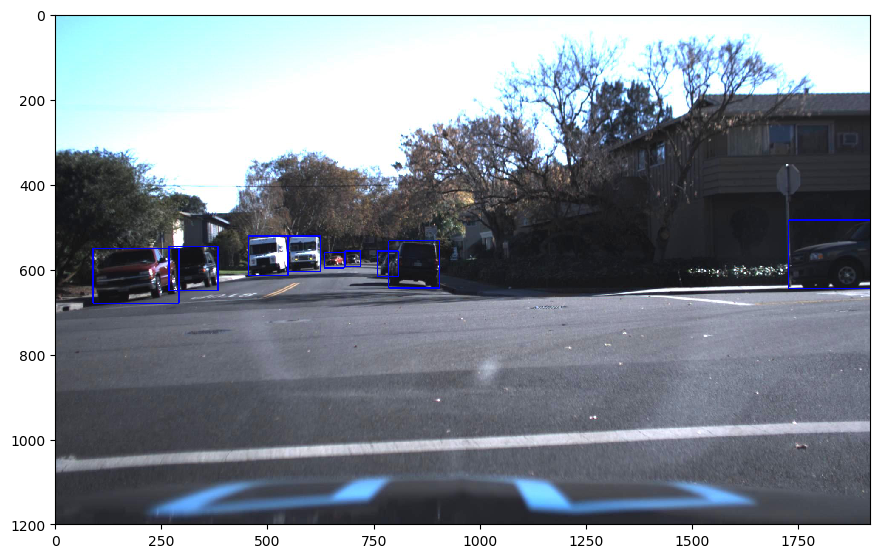

In [5]:
#### extract features and labels
key = car_frames[0]
frame_path = './object-detection-crowdai\\\{0:s}'.format(key)
print(frame_path)
feature_box = []
for frame_data in car_frames_data[key]:
    feature_box.append([(int(frame_data['xmin']), int(frame_data['ymin'])),(int(frame_data['xmax']),int(frame_data['ymax']))])

frame = read_img(frame_path)
frame = draw_boxes(frame, feature_box, thick=2)

fig = get_new_figure()
plt.imshow(frame)

In [6]:
from sys import stdout

In [92]:
def resize(img, new_size):
    if(new_size is not None):
        rows, cols, ch = img.shape
        if (rows > cols):
            r = float(new_size) / rows
            dim = (int(cols * r), new_size)
        else:
            r = float(new_size) / cols
            dim = (new_size, int(rows * r))
        try:
            img0 = cv2.resize(img, dim, interpolation = cv2.INTER_CUBIC)
            rows, cols, ch = img0.shape
            diff = abs(rows-cols)
            img = np.zeros((new_size, new_size, ch), dtype=np.uint8)
            if (rows > cols):
                img[:,0:rows//2] = np.tile(img0[:,0].reshape(rows,1,3), (1, rows//2, 1))
                img[:,rows//2:] = np.tile(img0[:,-1].reshape(rows,1,3), (1, rows-rows//2, 1))
                img = cv2.medianBlur(img,25)
                img[:,diff//2:cols+diff//2] = img0
            else:
                img[0:cols//2] = np.tile(img0[0], (cols//2, 1,1))
                img[cols//2:] = np.tile(img0[-1], (cols-cols//2, 1,1))
                img = cv2.medianBlur(img,25)
                img[diff//2:rows+diff//2] = img0
                
        except Exception:
            print('\n>> The image couldn\'t be resized: ', img.shape)
            img = np.zeros((new_size, new_size, ch), dtype=np.uint8)
            
    return img


def resize2(img, new_size):
    if(new_size is not None):
        try:
            dim = (new_size, new_size)
            img = cv2.resize(img, dim, interpolation = cv2.INTER_CUBIC)
                
        except Exception:
            print('\n>> The image couldn\'t be resized: ', img.shape)
            img = np.zeros((new_size, new_size, ch), dtype=np.uint8)
            
    return img


def save_feature(img, name, is_car=True, new_size=None):
    #img = resize(img, new_size)
    img = resize2(img, new_size)
    if (is_car):
        path = './dataset/features/car\\\{0:s}'.format(name)
    else:
        path = './dataset/features/noncar\\\{0:s}'.format(name)
    cv2.imwrite(path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    
    
def extract_features_labels_crowdai(car_frames, labels_car, labels_noncar):
    global count
    if(len(car_frames)==0): raise ValueError('"car_frames" is empty!')
    if(len(car_frames)>1):
        car_frames1 = car_frames[0:len(car_frames)//2]
        car_frames2 = car_frames[len(car_frames)//2:]

        extract_features_labels_crowdai(car_frames1, labels_car, labels_noncar)
        extract_features_labels_crowdai(car_frames2, labels_car, labels_noncar)
    elif(len(car_frames)==1):
        key = car_frames[0]
        frame_path = './object-detection-crowdai\\\{0:s}'.format(key)
        frame = read_img(frame_path)
        rows, cols, ch = frame.shape
        for frame_data in car_frames_data[key]:
            count+=1
            name = '{0:0>5d}.jpg'.format(count)
            
            # To prevent 0 dimension cropped image increase the cropping size 1 pixel 
            ymin = np.max([0, int(frame_data['ymin']) - 1])
            ymax = np.min([rows, int(frame_data['ymax']) + 1])
            xmin = np.max([0, int(frame_data['xmin']) - 1])
            xmax = np.min([cols, int(frame_data['xmax']) + 1])
            
            feature = frame[ymin:ymax, xmin:xmax]
            is_car = ('Truck'==frame_data['Label']) or ('Car'==frame_data['Label'])
            save_feature(feature, name, is_car, new_size=64)
            if (is_car):
                labels_car[name] = 'car'
            else:
                labels_noncar[name] = 'noncar'
                    
            stdout.write('\r>> 72064/{0:d}'.format(count))
            stdout.flush()

In [93]:
global count
count=0

labels_car = {}
labels_noncar = {}
extract_features_labels_crowdai(car_frames, labels_car, labels_noncar)
print('\n>> Done!')

>> 72064/72064
>> Done!


### GTI vehicle image database, the KITTI vision benchmark suite

In [94]:
def copy_images(files, labels, is_car):
    global count
    nn = count
    print('>> Adding new "{0}" images.'.format('car' if is_car else 'noncar'))
    for file in files:
        count+=1
        name = '{0:0>5d}.jpg'.format(count)
        labels[name] = 'car' if is_car else 'noncar'
        img = read_img(file)
        if (is_car):
            path = './dataset/features/car\\\{0:s}'.format(name)
        else:
            path = './dataset/features/noncar\\\{0:s}'.format(name)
        cv2.imwrite(path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        stdout.write('\r>> {0:d}/{1:d}'.format(len(files),count-nn))
        stdout.flush()
    print('\n>> Total (=count): {0}'.format(count))
    print('>> Done!\n')

In [140]:
global count
count=0 
labels_car = {}
labels_noncar = {}

car_images = glob.glob('./dataset/features-reviewed/car/*.jpg')
noncar_images = glob.glob('./dataset/features-reviewed/noncar/*.jpg')
copy_images(car_images, labels_car, is_car=True)
copy_images(noncar_images, labels_noncar, is_car=False)

>> Adding new "car" images.
>> 35725/35725
>> Total (=count): 35725
>> Done!

>> Adding new "noncar" images.
>> 5675/5675
>> Total (=count): 41400
>> Done!



In [141]:
print(count)

41400


In [142]:
count=41400
car_images = glob.glob('./vehicles/**/*.png')
noncar_images = glob.glob('./non-vehicles/**/*.png')
copy_images(car_images, labels_car, is_car=True)
copy_images(noncar_images, labels_noncar, is_car=False)

>> Adding new "car" images.
>> 8792/8792
>> Total (=count): 50192
>> Done!

>> Adding new "noncar" images.
>> 8968/8968
>> Total (=count): 59160
>> Done!



In [9]:
def write_dict_to_cvs(csv_file, headers, dict_data):
    with open(csv_file, 'w', newline='') as f:
        w = csv.writer(f)
        w.writerow(headers)
        for key, val in dict_data.items():
            w.writerow([key, val])

In [333]:
headers = ['img_name','content']
write_dict_to_cvs('./dataset/labels_car.csv', headers,labels_car)
write_dict_to_cvs('./dataset/labels_noncar.csv', headers,labels_noncar)
print('>> Done!')

>> Done!


In [10]:
def read_cvs_to_dict(csv_file):
    with open(csv_file, mode='r') as infile:
        reader = csv.reader(infile)
        headers = next(reader)
        mydict = dict(reader)
    return mydict, headers

In [7]:
labels_car, headers = read_cvs_to_dict('./dataset/labels_car.csv')
labels_noncar, headers = read_cvs_to_dict('./dataset/labels_noncar.csv')
print('>> Number of car images: {}'.format(len(labels_car.keys())))
print('>> Number of noncar images: {}'.format(len(labels_noncar.keys())))
print('>> Done!')

>> Number of car images: 75181
>> Number of noncar images: 14643
>> Done!


In [11]:
# def copy_extera_images(files, labels, is_car):
#     global count
#     nn = count
#     print('>> Adding new "{0}" images.'.format('car' if is_car else 'noncar'))
#     for file in files:
#         count+=1
#         name = '{0:0>5d}.jpg'.format(count)
#         labels[name] = 'car' if is_car else 'noncar'
#         img = read_img(file)
#         if (is_car):
#             path = './dataset/features/car\\\{0:s}'.format(name)
#         else:
#             path = './dataset/features/noncar\\\{0:s}'.format(name)
#         cv2.imwrite(path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
#         stdout.write('\r>> {0:d}/{1:d}'.format(len(files),count-nn))
#         stdout.flush()
#     print('\n>> Total (=count): {0}'.format(count))
#     print('>> Done!\n')

In [143]:
global count
count = len(labels_car.keys())+len(labels_noncar.keys())
feature_car_path = './extera-video-data/features/car'
feature_ncar_path = './extera-video-data/features/noncar'

extera_noncar_images = glob.glob('{0:s}/*.jpg'.format(feature_ncar_path))
print('>> count:', len(extera_noncar_images))
print('>> sample:', extera_noncar_images[0])
copy_images(extera_noncar_images, labels_noncar, is_car=False)

>> count: 956
>> sample: ./extera-video-data/features/noncar\00003.jpg
>> Adding new "noncar" images.
>> 956/956
>> Total (=count): 60116
>> Done!



In [144]:
headers = ['img_name','content']
write_dict_to_cvs('./dataset/labels_car.csv', headers,labels_car)
write_dict_to_cvs('./dataset/labels_noncar.csv', headers,labels_noncar)
print('>> Done!')

>> Done!


In [329]:
labels_car, headers = read_cvs_to_dict('./dataset/labels_car.csv')
labels_noncar, headers = read_cvs_to_dict('./dataset/labels_noncar.csv')
print('>> Number of car images: {}'.format(len(labels_car.keys())))
print('>> Number of noncar images: {}'.format(len(labels_noncar.keys())))
print('>> Done!')

>> Number of car images: 44517
>> Number of noncar images: 15599
>> Done!


In [332]:
global count
count = len(labels_car.keys())+len(labels_noncar.keys())
feature_car_path = './extera-video-data/features/car'

extera_car_images = glob.glob('{0:s}/*.jpg'.format(feature_car_path))
print('>> count:', len(extera_car_images))
print('>> sample:', extera_car_images[0])
copy_images(extera_car_images, labels_car, is_car=True)

>> count: 402
>> sample: ./extera-video-data/features/car\00183.jpg
>> Adding new "car" images.
>> 402/402
>> Total (=count): 60518
>> Done!



In [334]:
labels_car, headers = read_cvs_to_dict('./dataset/labels_car.csv')
labels_noncar, headers = read_cvs_to_dict('./dataset/labels_noncar.csv')
print('>> Number of car images: {}'.format(len(labels_car.keys())))
print('>> Number of noncar images: {}'.format(len(labels_noncar.keys())))
print('>> Done!')

>> Number of car images: 44919
>> Number of noncar images: 15599
>> Done!


### Plot Some Random Data

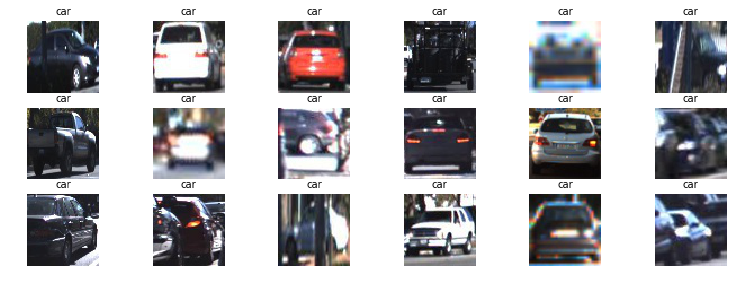

In [336]:
n = 3
count = n*n
offset = random.randint(0, 10000)
img_names = list(labels_car.keys())[offset:offset+2*count]
img_labels = list(labels_car.values())[offset:offset+2*count]
# plot
plot_sample_data(img_names, img_labels, v_plot_count=n, fig_size=(count*1.5, n*1.5,), path='./dataset/features/car/')

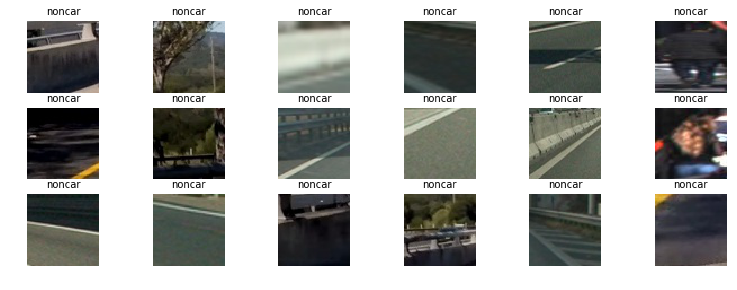

In [148]:
n = 3
count = n*n
offset = random.randint(0, 10000)
img_names = list(labels_noncar.keys())[offset:offset+2*count]
img_labels = list(labels_noncar.values())[offset:offset+2*count]
# plot
plot_sample_data(img_names, img_labels, v_plot_count=n, fig_size=(count*1.5, n*1.5,), path='./dataset/features/noncar/')

### Convert Image to Histogram of Oriented Gradients (HOG)

In [104]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True, trans_sqrt=False):
    """
    A function to return HOG features and visualization
    """
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=trans_sqrt, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=trans_sqrt, 
                       visualise=vis, feature_vector=feature_vec)
        return features

#### Calculate and Visualize HOG for One Sample Data

In [2]:
from skimage import color

./dataset/features/car\49063.jpg
(3600,)
car


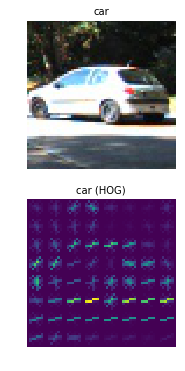

In [342]:
features = glob.glob('./dataset/features/car/*.jpg')
sample = shuffle(features, n_samples=1)[0]
print(sample)
# sample = './dataset/features/car\\04124.jpg'
# sample_img = color.rgb2gray(read_img(sample))
sample_img = read_img(sample)
sample_gray = cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY)
_, hog_img = get_hog_features(sample_gray, 9, 8, 4, vis=True, feature_vec=True, trans_sqrt=False)
print(_.shape)
name = sample.split('\\')[1]
print(labels_car[name])
# all
samples= [sample_img, hog_img]
# titles = np.concatenate((sample_cars_title, sample_noncars_title))
titles = [labels_car[name], labels_car[name] + ' (HOG)']
# #plot
plot_sample_data_img(samples, titles, v_plot_count=2, fig_size=(6, 6))

./dataset/features/noncar\41277.jpg
(3600,)
noncar


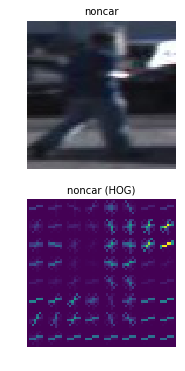

In [259]:
features = glob.glob('./dataset/features/noncar/*.jpg')
sample = shuffle(features, n_samples=1)[0]
print(sample)
# sample = './dataset/features/noncar\\04124.jpg'
# sample_img = color.rgb2gray(read_img(sample))
sample_img = read_img(sample)
sample_gray = cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY)
_, hog_img = get_hog_features(sample_gray, 9, 8, 4, vis=True, feature_vec=True, trans_sqrt=False)
print(_.shape)
name = sample.split('\\')[1]
print(labels_noncar[name])
# all
samples= [sample_img, hog_img]
# titles = np.concatenate((sample_cars_title, sample_noncars_title))
titles = [labels_noncar[name], labels_noncar[name] + ' (HOG)']
# #plot
plot_sample_data_img(samples, titles, v_plot_count=2, fig_size=(6, 6))

### Extract HOG Features from an Array of Car and Non-Car Images

In [289]:
def bin_spatial(img, size=(32, 32)):
    """
    A function to compute binned color features
    """
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


def color_hist(img, nbins=32, bins_range=(0, 256)):
    """
    - Define a function to compute color histogram features 
    - NEED TO CHANGE bins_range if reading ".png" files with mpimg!
    """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), 
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_f = False, hist_f=False):
    """
    - A function to extract features from a list of images
    - Have this function call bin_spatial() and color_hist()
    """
    print('>> Extract features for:')
    print('   - {0} images'.format(len(imgs)))
    print('   - Color space is {}'.format(color_space))
    print('   - hist_bins={0}, hist_range ={1}'.format(hist_bins, hist_range))
    print('   - orient={0}, pix_per_cell={1}, cell_per_block={2}'.format(orient, pix_per_cell, cell_per_block))
    print('   - hog_channel={0}\n'.format(hog_channel))
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for idx, file in enumerate(imgs):
        file_features = []
        # Read in each one by one
        image = read_img(file)
        # Apply color conversion
        feature_image = convert_color(image, conv=color_space)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features= []
        if(spatial_f):
            spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = []
        if(hist_f):
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Apply get_hog_features()
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        
        stdout.write('\r>> {0:d}/{1:d}'.format(len(imgs),idx+1))
        stdout.flush()
    
    print('\n>> Done!\n')
    # Return list of feature vectors
    return features

### Feature Extraction
Steps are as following:
- Extract the features for data set.
- Combine them
- Define the labels
- Shuffle and split

First, define some usefule parameters:

Extract features from data set for:
- 6 color spaces which is `colorspaces`
- 1 HOG channel which is `hog_channel='All'`
- 2 orient values which is `orient`
- `pix_per_cell = 8`, `cell_per_block = 2`

in total 14 different combinations for extracting features.
> **The folloing code cell takes ~8min to run.**

In [274]:
ccc = sorted(glob.glob('./dataset/features/car/*.jpg'))
cc1 = ccc[0:10]
cc2 = ccc[40000:40010]
print(cc1)
print(cc2)
print(np.concatenate((cc1, cc2)))

['./dataset/features/car\\00001.jpg', './dataset/features/car\\00002.jpg', './dataset/features/car\\00003.jpg', './dataset/features/car\\00004.jpg', './dataset/features/car\\00005.jpg', './dataset/features/car\\00006.jpg', './dataset/features/car\\00007.jpg', './dataset/features/car\\00008.jpg', './dataset/features/car\\00009.jpg', './dataset/features/car\\00010.jpg']
['./dataset/features/car\\45676.jpg', './dataset/features/car\\45677.jpg', './dataset/features/car\\45678.jpg', './dataset/features/car\\45679.jpg', './dataset/features/car\\45680.jpg', './dataset/features/car\\45681.jpg', './dataset/features/car\\45682.jpg', './dataset/features/car\\45683.jpg', './dataset/features/car\\45684.jpg', './dataset/features/car\\45685.jpg']
['./dataset/features/car\\00001.jpg' './dataset/features/car\\00002.jpg'
 './dataset/features/car\\00003.jpg' './dataset/features/car\\00004.jpg'
 './dataset/features/car\\00005.jpg' './dataset/features/car\\00006.jpg'
 './dataset/features/car\\00007.jpg' '.

In [295]:
0 if 10-2 > 0 else 2

0

In [343]:
def get_car_noncar_files(number_of_samples = None):
    cars = sorted(glob.glob('./dataset/features/car/*.jpg'))
    noncars = sorted(glob.glob('./dataset/features/noncar/*.jpg'))
    
#     if(number_of_samples is not None):
#         nsample = min(min(number_of_samples, len(cars)),
#                       min(number_of_samples, len(noncars)))
#         ncar = nsample
#         nncar = nsample
#     else:
#         nsample = min(len(cars), len(noncars))
#         ncar = nsample + int(abs(len(cars)-nsample) * 0.40)
#         nncar = nsample
        
    ncar1 = min(number_of_samples, 9195)
    ncar2 = 200
    cars1 = shuffle(cars[35725:], n_samples=ncar1)
    cars2 = shuffle(cars[0:35725], n_samples=ncar2)
    cars = np.concatenate((cars1, cars2))
    
    nncar1 = min(ncar1, 9924)
    nncar2 = ncar2
    noncars1 = shuffle(noncars[5675:], n_samples=nncar1)
    noncars2 = shuffle(noncars[0:5675], n_samples=nncar2)
    noncars = np.concatenate((noncars1, noncars2))
    
    return cars, noncars


def extract_features_car_noncar(cars, noncars, color_space='RGB', spatial_size=(32, 32),
                                hist_bins=32, hist_range=(0, 256), orient=9, 
                                pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):
    car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, hist_range=hist_range, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
    noncar_features = extract_features(noncars, color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, hist_range=hist_range, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
    
    return car_features, noncar_features

Build the training and testing data set. Training data set contains 80% of all data set and testing data contains 20% of it.

In [319]:
def shuffle_and_split(car_features, noncar_features, ratio =0.2):    
    # Define the features
    X = np.vstack((shuffle(car_features), shuffle(noncar_features))).astype(np.float64)     
    # Define the labels
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio,
                                                        random_state=rand_state)

    print('>> Training data set: features={0}, labels={1}'.format(len(X_train), len(y_train)))
    print('>> Testing data set: features={0}, labels={1}'.format(len(X_test), len(y_test)))
    
    return X_train, X_test, y_train, y_test

In [320]:
def get_scaler(X):
    X_scaler = StandardScaler().fit(X)
    #X_scaler = RobustScaler().fit(X)
    
    return X_scaler

    
def plot_scaled_data(img, raw, scaled, tag):
    # Plot an example of raw and scaled features
    car_ind = np.random.randint(0, nsample)
    fig = plt.figure(figsize=(12,2))
    plt.subplot(131)
    plt.imshow(img)
    plt.title('Original Image ({0:s})'.format(tag))
    plt.subplot(132)
    plt.plot(raw)
    plt.title('Raw Features ({0:s})'.format(tag))
    plt.subplot(133)
    plt.plot(scaled)
    plt.title('Normalized Features ({0:s})'.format(tag))

Now that we have split into training and test sets, we can scale our features. It's important to do the scaling after splitting the data, otherwise you are allowing the scaler to peer into your test data!

### Plot sample data

In [29]:
# # car
# ns = 1000
# idx = np.random.randint(0, ns)
# org_img = read_img(cars[idx])
# raw_scar = car_features[idx]
# norm_scar = X_scaler.transform(car_features[0:ns])[idx]
# plot_scaled_data(org_img, raw_scar, norm_scar, 'car')
# # non-car
# idx = np.random.randint(0, ns)
# org_img = read_img(noncars[idx])
# raw_sncar = noncar_features[idx]
# norm_sncar = X_scaler.transform(noncar_features[0:ns])[idx]
# plot_scaled_data(org_img, raw_sncar, norm_sncar, 'non-car')

In [ ]:
# # Save a dictionary into a pickle file.
# import pickle

# all_features = {'car':car_features[0:100], 'noncar':noncar_features[0:10]}
# file = './dataset/normalized_features.p'
# pickle.dump(all_features, open(file, 'wb'))
# print('>> Data seved in "{0:s}"'.format(file))

### Train Classifier
I used `LinearSVC()`  as my classifier.

In [322]:
def train_classifier(clf, scaled_X_train, scaled_X_test, y_train, y_test):
    # Check the training time for the SVC
    t=time.time()
    clf.fit(scaled_X_train, y_train)
    t2 = time.time()
    ttrain = round(t2-t, 3)
    print('[+] {0} seconds to train SVC...'.format(ttrain))
    #trained_classifier['ttrain'].append(ttrain)
    print('----------------------------------------------')
    
    count = 10
    accuracy = round(clf.score(scaled_X_test, y_test), 4)
    print('>> Accuracy = {0:7.4f}'.format(accuracy))
    
    # Check the prediction time for a single sample
    t=time.time()
    print('>> Predicted      : {0}'.format(clf.predict(scaled_X_test[0:count])))
    print('>> Expected labels: {0}'.format(y_test[0:count]))
    t2 = time.time()
    tpred = round(t2-t, 5)
    #trained_classifier['tpred'].append(tpred)
    print('[+] {0} seconds to predict {1} labels with SVC.'.format(tpred, count))
    print('______________________________________________')
    
    return clf, accuracy

In [323]:
def build_and_train_classifier(color_space='RGB', spatial_size=(32, 32),
            hist_bins=32, hist_range=(0, 256), orient=9,
            pix_per_cell=8, cell_per_block=2, hog_channel='ALL', number_of_samples=None):
    print('>> Get car and non-car files...')
    cars, noncars = get_car_noncar_files(number_of_samples)
    print('>> Done!')

    print('----------------------------------------------')
    print('>> Get car and non-car features...')
    car_features, noncar_features =\
        extract_features_car_noncar(
            cars, noncars, color_space=color_space,
            spatial_size=spatial_size,
            hist_bins=hist_bins, hist_range=hist_range, orient=orient,
            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)

        
    print('----------------------------------------------')
    print('>> Shuffle and split data...')
    X_train, X_test, y_train, y_test =\
        shuffle_and_split(car_features, noncar_features, ratio =0.2)
    print('>> Done!')

    print('----------------------------------------------')
    print('>> Get scaler...')
    # Fit a per-column scaler only on the training data
    X_scaler = get_scaler(X_train)
    print('>> Done!')
    
    print('----------------------------------------------')
    print('>> Transform train and test data sets using "X_scaler"...')
    # Apply the scaler to both X_train and X_test
    """
    Now that we have split into training and test sets, we can scale our 
    features. It's important to do the scaling after splitting the data, 
    otherwise you are allowing the scaler to peer into your test data!
    """
    scaled_X_train = X_scaler.transform(X_train)
    scaled_X_test = X_scaler.transform(X_test)
    print('>> Done!')

    print('----------------------------------------------')
    print('>> Train classifier...')
    svc = LinearSVC()
    svc, accuracy =\
        train_classifier(svc, scaled_X_train, scaled_X_test, y_train, y_test)
        
    return X_scaler, svc, accuracy

In [47]:
colorspaces = {0:'YUV', 1:'RGB', 2:'HSV', 3:'LUV', 4:'HLS', 5:'YCrCb'}
hog_channels = {0:0, 1:1, 2:2, 3:'ALL'}

spatial_size=(32, 32)
hist_bins=32
hist_range=(0, 256)
orient=9
pix_per_cell=8
cell_per_block=2
hog_channel='ALL'

In [48]:
training_storage = {}
for cs in colorspaces.values():
    print('___________________________________________________________')
    print('>> Selected color space is "{0:s}"...'.format(cs))
    X_scaler, svc, accuracy =\
        build_and_train_classifier(color_space=cs, spatial_size=spatial_size,
            hist_bins=hist_bins, hist_range=hist_range, orient=orient,
            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
    
    storage = {'scaler': X_scaler, 'svc': svc, 'accuracy': accuracy}
    training_storage[cs] = storage
    print('\n>> Data saved!\n')

___________________________________________________________
>> Selected color space is "YUV"...
>> Get car and non-car files...
>> Done!
----------------------------------------------
>> Get car and non-car features...
>> Extract features for:
   - 52114 images
   - Color space is YUV
   - hist_bins=32, hist_range =(0, 256)
   - orient=9, pix_per_cell=8, cell_per_block=2
   - hog_channel=ALL

>> 52114/52114
>> Done!

>> Extract features for:
   - 17514 images
   - Color space is YUV
   - hist_bins=32, hist_range =(0, 256)
   - orient=9, pix_per_cell=8, cell_per_block=2
   - hog_channel=ALL

>> 17514/17514
>> Done!

----------------------------------------------
>> Shuffle and split data...
>> Training data set: features=55702, labels=55702
>> Testing data set: features=13926, labels=13926
>> Done!
----------------------------------------------
>> Get scaler...
>> Done!
----------------------------------------------
>> Transform train and test data sets using "X_scaler"...
>> Done!
----

>> Expected labels: [1. 1. 1. 0. 0. 1. 1. 1. 1. 1.]
[+] 0.00802 seconds to predict 10 labels with SVC.
______________________________________________

>> Data saved!



In [49]:
import pickle

In [50]:
pickle.dump(training_storage, open("training_storage_01.p", "wb"))

In [51]:
training_storage = pickle.load(open("training_storage_01.p", "rb"))

In [344]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size=(16, 16)
hist_bins=32
hist_range=(0, 256)
orient=11
pix_per_cell=16
cell_per_block=2
hog_channel='ALL' # Can be 0, 1, 2, or 'ALL'

print('___________________________________________________________')
print('>> Selected color space is "{0:s}"...'.format(color_space))
X_scaler, svc, accuracy =\
    build_and_train_classifier(color_space=color_space, spatial_size=spatial_size,
        hist_bins=hist_bins, hist_range=hist_range, orient=orient,
        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,number_of_samples=20000)

___________________________________________________________
>> Selected color space is "YUV"...
>> Get car and non-car files...
>> Done!
----------------------------------------------
>> Get car and non-car features...
>> Extract features for:
   - 9395 images
   - Color space is YUV
   - hist_bins=32, hist_range =(0, 256)
   - orient=11, pix_per_cell=16, cell_per_block=2
   - hog_channel=ALL

>> 9395/9395
>> Done!

>> Extract features for:
   - 9395 images
   - Color space is YUV
   - hist_bins=32, hist_range =(0, 256)
   - orient=11, pix_per_cell=16, cell_per_block=2
   - hog_channel=ALL

>> 9395/9395
>> Done!

----------------------------------------------
>> Shuffle and split data...
>> Training data set: features=15032, labels=15032
>> Testing data set: features=3758, labels=3758
>> Done!
----------------------------------------------
>> Get scaler...
>> Done!
----------------------------------------------
>> Transform train and test data sets using "X_scaler"...
>> Done!
--------

-----------------------


## Features extraction

Here we define functions for features extraction (HOG, binned color and color histogram features). The functions are based on code from the Udacity's lectures.

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True: # Call with two outputs if vis==True to visualize the HOG
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      # Otherwise call with one output
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    return cv2.resize(img, size).ravel() 

# Define a function to compute color histogram features 
def color_hist(img, nbins=32):
    ch1 = np.histogram(img[:,:,0], bins=nbins, range=(0, 256))[0]#We need only the histogram, no bins edges
    ch2 = np.histogram(img[:,:,1], bins=nbins, range=(0, 256))[0]
    ch3 = np.histogram(img[:,:,2], bins=nbins, range=(0, 256))[0]
    hist = np.hstack((ch1, ch2, ch3))
    return hist

The `extract_features` function extracl all nessesary features from images. It also augment the train dataset by horizontal image flipping.

In [4]:
# Define a function to extract features from a list of images
def img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel):
    file_features = []
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #print 'spat', spatial_features.shape
        file_features.append(spatial_features)
    if hist_feat == True:
         # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #print 'hist', hist_features.shape
        file_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
        else:
            feature_image = cv2.cvtColor(feature_image, cv2.COLOR_LUV2RGB)
            feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
            hog_features = get_hog_features(feature_image[:,:], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                #print 'hog', hog_features.shape
            # Append the new feature vector to the features list
        file_features.append(hog_features)
    return file_features


def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file_p in imgs:
        file_features = []
        image = cv2.imread(file_p) # Read in each imageone by one
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        file_features = img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel)
        features.append(np.concatenate(file_features))
        feature_image=cv2.flip(feature_image,1) # Augment the dataset with flipped images
        file_features = img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel)
        features.append(np.concatenate(file_features))
    return features # Return list of feature vectors

## Data loading
Here we create lists of [vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [not-vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) images provided by Udacity. Corrisponding folders contain unzilled archives.

In [5]:
# Read in cars and notcars
images = glob.glob('./dataset2/*vehicles/*/*')
cars = []
notcars = []
for image in images:
    if 'non' in image:
        notcars.append(image)
    else:
        cars.append(image)
## Uncomment if you need to reduce the sample size
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]
print(len(cars))
print(len(notcars))

8792
8968


As we can see, there are about the same number of objects of both classes, so, wo do not need to balance number of images.

## Classifier

The following code chunk creates feature list for the training data. Feature list is normolized by the `StandardScaler()` method from `sklearn`. The data is splitted into thaining and testing subsets (80% and 20%).


The classifier (Linear SVM) is trained there as well. 

In [12]:
# Define parameters for feature extraction
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [751]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print ('Car samples: ', len(car_features))
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print ('Notcar samples: ', len(notcar_features))
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

X_scaler = StandardScaler().fit(X) # Fit a per-column scaler
scaled_X = X_scaler.transform(X) # Apply the scaler to X

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)))) # Define the labels vector

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=22)

print('Using:',orient,'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
svc = LinearSVC(loss='hinge') # Use a linear SVC 
t=time.time() # Check the training time for the SVC
svc.fit(X_train, y_train) # Train the classifier
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) # Check the score of the SVC

Car samples:  17584
Notcar samples:  17936
Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2432
9.02 Seconds to train SVC...
Test Accuracy of SVC =  0.9894


In [752]:
training_storage_01 = {}
storage = {'scaler': X_scaler
           ,'svc': svc
           ,'color_space': color_space # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
           ,'orient': orient  # HOG orientations
           ,'pix_per_cell': pix_per_cell # HOG pixels per cell
           ,'cell_per_block': cell_per_block # HOG cells per block
           ,'hog_channel': hog_channel # Can be 0, 1, 2, or "ALL"
           ,'spatial_size': spatial_size # Spatial binning dimensions
           ,'hist_bins': hist_bins    # Number of histogram bins
           ,'spatial_feat': spatial_feat # Spatial features on or off
           ,'hist_feat': hist_feat # Histogram features on or off
           ,'hog_feat': hog_feat # HOG features on or off
          }
training_storage_01[color_space] = storage

In [753]:
# pickle.dump(training_storage_01, open("training_storage_final.p", "wb"))
pickle.dump(training_storage_01, open("training_storage_final_YCrCb.p", "wb"))
print('>> Data saved!')

>> Data saved!


In [6]:
# training_storage_01 = pickle.load(open("training_storage_final.p", "rb"))
training_storage_01 = pickle.load(open("training_storage_final_YCrCb.p", "rb"))
print('>> Loading completed!')
print(training_storage_01)

>> Loading completed!
{'YCrCb': {'spatial_feat': True, 'hog_channel': 0, 'color_space': 'YCrCb', 'orient': 8, 'pix_per_cell': 8, 'spatial_size': (16, 16), 'hist_feat': True, 'hist_bins': 32, 'svc': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0), 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'hog_feat': True, 'cell_per_block': 2}}


### Selecting the Classifirer
First I sort the results based on the obtained accuracy:

Based on the above results, I choose the first one (`model_index = 0`) with higher accuracy `0.9887`.

### Detecting Cars in a Frame Using Classifier
`detect_cars()` is responsible to use every calculated information above to detect cars in a frame. **For implementation I used the code in the course.**

In [291]:
ccc= [1, 2,3,4,5,6]
np.hstack((ccc,[], []))

array([1., 2., 3., 4., 5., 6.])

In [38]:
# # Define a function to extract features from a single image window
# # This function is very similar to extract_features()
# # just for a single image rather than list of images
# def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
#                         hist_bins=32, orient=9, 
#                         pix_per_cell=8, cell_per_block=2, hog_channel=0,
#                         spatial_feat=True, hist_feat=True, hog_feat=True):    
#     #1) Define an empty list to receive features
#     img_features = []
#     #2) Apply color conversion if other than 'RGB'
#     if color_space != 'RGB':
#         if color_space == 'HSV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#         elif color_space == 'LUV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
#         elif color_space == 'HLS':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
#         elif color_space == 'YUV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
#         elif color_space == 'YCrCb':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
#     else: feature_image = np.copy(img)      
#     #3) Compute spatial features if flag is set
#     if spatial_feat == True:
#         spatial_features = bin_spatial(feature_image, size=spatial_size)
#         #4) Append features to list
#         img_features.append(spatial_features)
#     #5) Compute histogram features if flag is set
#     if hist_feat == True:
#         hist_features = color_hist(feature_image, nbins=hist_bins)
#         #6) Append features to list
#         img_features.append(hist_features)
#     #7) Compute HOG features if flag is set
#     if hog_feat == True:
#         if hog_channel == 'ALL':
#             hog_features = []
#             for channel in range(feature_image.shape[2]):
#                 hog_features.extend(get_hog_features(feature_image[:,:,channel], 
#                                     orient, pix_per_cell, cell_per_block, 
#                                     vis=False, feature_vec=True))      
#         else:
#             hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
#                         pix_per_cell, cell_per_block, vis=False, feature_vec=True)
#         #8) Append features to list
#         img_features.append(hog_features)

#     #9) Return concatenated array of features
#     return np.concatenate(img_features)

# # Define a function you will pass an image 
# # and the list of windows to be searched (output of slide_windows())
# def search_windows(img, windows, clf, scaler, color_space='RGB', 
#                     spatial_size=(32, 32), hist_bins=32, 
#                     hist_range=(0, 256), orient=9, 
#                     pix_per_cell=8, cell_per_block=2, 
#                     hog_channel=0, spatial_feat=True, 
#                     hist_feat=True, hog_feat=True):

#     #1) Create an empty list to receive positive detection windows
#     on_windows = []
#     #2) Iterate over all windows in the list
#     for window in windows:
#         #3) Extract the test window from original image
#         test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
#         #4) Extract features for that window using single_img_features()
#         features = single_img_features(test_img, color_space=color_space, 
#                             spatial_size=spatial_size, hist_bins=hist_bins, 
#                             orient=orient, pix_per_cell=pix_per_cell, 
#                             cell_per_block=cell_per_block, 
#                             hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                             hist_feat=hist_feat, hog_feat=hog_feat)
#         #5) Scale extracted features to be fed to classifier
#         test_features = scaler.transform(np.array(features).reshape(1, -1))
#         #6) Predict using your classifier
#         prediction = clf.predict(test_features)
#         #7) If positive (prediction == 1) then save the window
#         if prediction == 1:
#             on_windows.append(window)
#     #8) Return windows for positive detections
#     return on_windows


# # Define a function that takes an image,
# # start and stop positions in both x and y, 
# # window size (x and y dimensions),  
# # and overlap fraction (for both x and y)
# def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
#                     xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
#     # If x and/or y start/stop positions not defined, set to image size
#     if x_start_stop[0] == None:
#         x_start_stop[0] = 0
#     if x_start_stop[1] == None:
#         x_start_stop[1] = img.shape[1]
#     if y_start_stop[0] == None:
#         y_start_stop[0] = 0
#     if y_start_stop[1] == None:
#         y_start_stop[1] = img.shape[0]
#     # Compute the span of the region to be searched    
#     xspan = x_start_stop[1] - x_start_stop[0]
#     yspan = y_start_stop[1] - y_start_stop[0]
#     # Compute the number of pixels per step in x/y
#     nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
#     ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
#     # Compute the number of windows in x/y
#     nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
#     ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
#     nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
#     ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
#     # Initialize a list to append window positions to
#     window_list = []
#     # Loop through finding x and y window positions
#     # Note: you could vectorize this step, but in practice
#     # you'll be considering windows one by one with your
#     # classifier, so looping makes sense
#     for ys in range(ny_windows):
#         for xs in range(nx_windows):
#             # Calculate window position
#             startx = xs*nx_pix_per_step + x_start_stop[0]
#             endx = startx + xy_window[0]
#             starty = ys*ny_pix_per_step + y_start_stop[0]
#             endy = starty + xy_window[1]
            
#             # Append window position to list
#             window_list.append(((startx, starty), (endx, endy)))
#     # Return the list of windows
#     return window_list


def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function to draw bounding boxes on an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img) # Make a copy of the image
    for bbox in bboxes: # Iterate through the bounding boxes
        cv2.rectangle(imcopy, 
                      bbox[0], 
                      bbox[1], color, thick)
    return imcopy


def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=8, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


# A function to show an image
def show_img(img):
    if len(img.shape)==3: #Color BGR image
        plt.figure()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else: # Grayscale image
        plt.figure()
        plt.imshow(img, cmap='gray')
        
        
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, color_space='YCrCb', hog_channel = 0, spatial_f=False, hist_f=False):
    """
    Assumptions:
        + spatial_feat=True
        + hist_feat=True
        + hog_feat=True
        + hog_channel = 'ALL'
    """
    # Create an empty list to receive positive detection windows
    window_list = []

    img = img.astype(np.float32)
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            if(hog_channel == 0):
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = hog_feat1
            elif(hog_channel == 1):
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = hog_feat2
            elif(hog_channel == 2):
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = hog_feat3
            elif(hog_channel == 'ALL'):
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = []
            if(spatial_f):
                spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = []
            if(hist_f):
                hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)

                new_window = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart))
                window_list.append(new_window)
                
    return window_list


def all_sliding_windows_scale(image, ystart, ystop, scale_list, svc, X_scaler, orient, pix_per_cell, 
                        cell_per_block, spatial_size, hist_bins, color_space=color_space):
    all_windows = []
    
    for scale in scale_list:
        windows = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                        cell_per_block, spatial_size, hist_bins, color_space=color_space)
        all_windows.append(windows)

    all_windows = [item for sublist in all_windows for item in sublist] 
    
    return all_windows


def all_sliding_windows(image):
    windows = slide_window(image, x_start_stop=[950, None], y_start_stop=[400, 656], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    # windows += slide_window(image, x_start_stop=[950, None], y_start_stop=[400, 656], 
    #                     xy_window=(96,96), xy_overlap=(0.75, 0.75))

    windows += slide_window(image, x_start_stop=[850, None], y_start_stop=[400, 600], 
                        xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    # windows += slide_window(image, x_start_stop=[850, None], y_start_stop=[400, 600], 
    #                     xy_window=(64,64), xy_overlap=(0.75, 0.75))

    windows += slide_window(image, x_start_stop=[850, None], y_start_stop=[400, 552], 
                        xy_window=(64, 64), xy_overlap=(0.65, 0.65))
    # windows += slide_window(image, x_start_stop=[750, None], y_start_stop=[400, 552], 
    #                     xy_window=(48,48), xy_overlap=(0.65, 0.65))

    windows += slide_window(image, x_start_stop=[800, 850], y_start_stop=[410, 496], 
                        xy_window=(48, 48), xy_overlap=(0.65, 0.65))
    # windows += slide_window(image, x_start_stop=[680, 850], y_start_stop=[410, 496], 
    #                     xy_window=(32,32), xy_overlap=(0.65, 0.65))

    windows += slide_window(image, x_start_stop=[800, 800], y_start_stop=[400, 464], 
                        xy_window=(32, 32), xy_overlap=(0.65, 0.65))
    # windows += slide_window(image, x_start_stop=[600, 800], y_start_stop=[400, 464], 
    #                     xy_window=(24,24), xy_overlap=(0.65, 0.65))
    return windows

(-0.5, 1279.5, 719.5, -0.5)

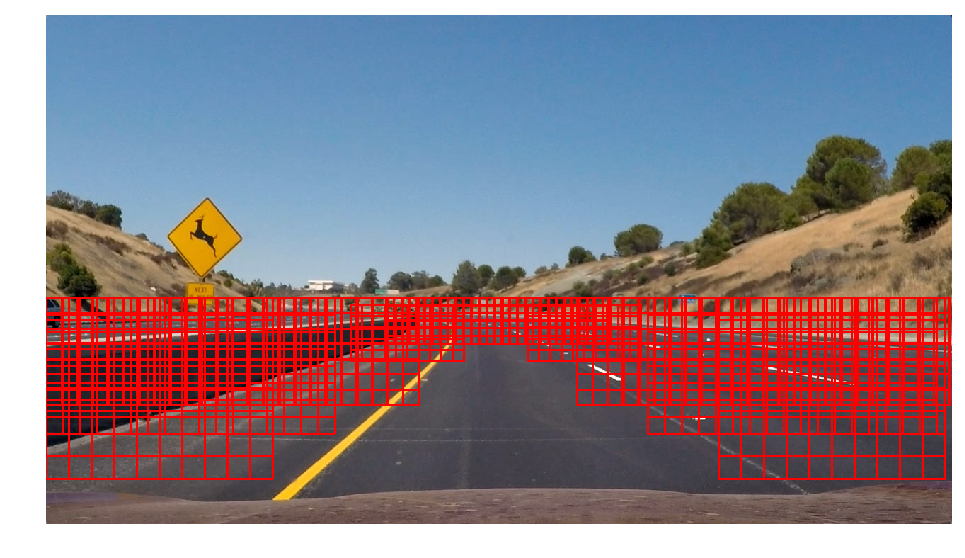

In [37]:
image = cv2.imread('test_images/test2.jpg')
windows = slide_window(image, x_start_stop=[950, None], y_start_stop=[400, 656], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
windows += slide_window(image, x_start_stop=[0, 1280-950], y_start_stop=[400, 656], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
# windows += slide_window(image, x_start_stop=[950, None], y_start_stop=[400, 656], 
#                     xy_window=(96,96), xy_overlap=(0.75, 0.75))

windows += slide_window(image, x_start_stop=[850, None], y_start_stop=[400, 600], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))
windows += slide_window(image, x_start_stop=[0, 1280-850], y_start_stop=[400, 600], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))
# windows += slide_window(image, x_start_stop=[850, None], y_start_stop=[400, 600], 
#                     xy_window=(64,64), xy_overlap=(0.75, 0.75))

windows += slide_window(image, x_start_stop=[750, None], y_start_stop=[400, 552], 
                    xy_window=(64, 64), xy_overlap=(0.65, 0.65))
windows += slide_window(image, x_start_stop=[0, 1280-750], y_start_stop=[400, 552], 
                    xy_window=(64, 64), xy_overlap=(0.65, 0.65))
# windows += slide_window(image, x_start_stop=[750, None], y_start_stop=[400, 552], 
#                     xy_window=(48,48), xy_overlap=(0.75, 0.75))

windows += slide_window(image, x_start_stop=[680, 850], y_start_stop=[410, 496], 
                    xy_window=(48, 48), xy_overlap=(0.65, 0.65))
windows += slide_window(image, x_start_stop=[1280-850,1280-680], y_start_stop=[410, 496], 
                    xy_window=(48, 48), xy_overlap=(0.65, 0.65))
# windows += slide_window(image, x_start_stop=[680, 850], y_start_stop=[410, 496], 
#                     xy_window=(32,32), xy_overlap=(0.65, 0.65))

windows += slide_window(image, x_start_stop=[600, 800], y_start_stop=[400, 464], 
                    xy_window=(32, 32), xy_overlap=(0.65, 0.65))
windows += slide_window(image, x_start_stop=[1280-800, 1280-600], y_start_stop=[400, 464], 
                    xy_window=(32, 32), xy_overlap=(0.65, 0.65))
# windows += slide_window(image, x_start_stop=[600, 800], y_start_stop=[400, 464], 
#                     xy_window=(24,24), xy_overlap=(0.65, 0.65))


# windows += slide_window(image, x_start_stop=[0, 350], y_start_stop=[420, 656], 
#                     xy_window=(128, 128), xy_overlap=(0.75, 0.75))

window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=2) 
# windows = slide_window(image, x_start_stop=[500, 880], y_start_stop=[400, 480], 
#                     xy_window=(48, 48), xy_overlap=(0.75, 0.75))
# window_img = draw_boxes(window_img, windows, color=(255, 0, 0), thick=6) 
fig = get_new_figure()
plt.imshow(cv2.cvtColor(window_img,cv2.COLOR_BGR2RGB))
plt.grid('off')
plt.axis('off')

In [786]:
test_images = np.array(glob.glob('./test_images/*.jpg'))
print(test_images)

['./test_images\\test1.jpg' './test_images\\test2.jpg'
 './test_images\\test3.jpg' './test_images\\test4.jpg'
 './test_images\\test5.jpg' './test_images\\test6.jpg'
 './test_images\\test7.jpg' './test_images\\test8.jpg']


In [787]:
# spatial_size = (32,32) # Spatial binning dimensions
# hist_bins = 32    # Number of histogram bins
# orient = 9  # HOG orientations
# pix_per_cell=8
# cell_per_block=2
# # Min and max in y to search in slide_window()
# ystart = 400
# ystop = 656 # => 400 + 4*8*8 = 400 + 256 = 656
# scale = 1.5
# color_space='LUV'

# svc = training_storage[color_space]['svc']
# X_scaler = training_storage[color_space]['scaler']

# idx = 0
# image = read_img(test_images[idx])
# draw_image = np.copy(image)

# hot_windows = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
#                         cell_per_block, spatial_size, hist_bins, color_space=color_space, hog_channel = 'ALL')

# window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
# fig = get_new_figure()
# plt.imshow(window_img)

2.87 Seconds to process test images


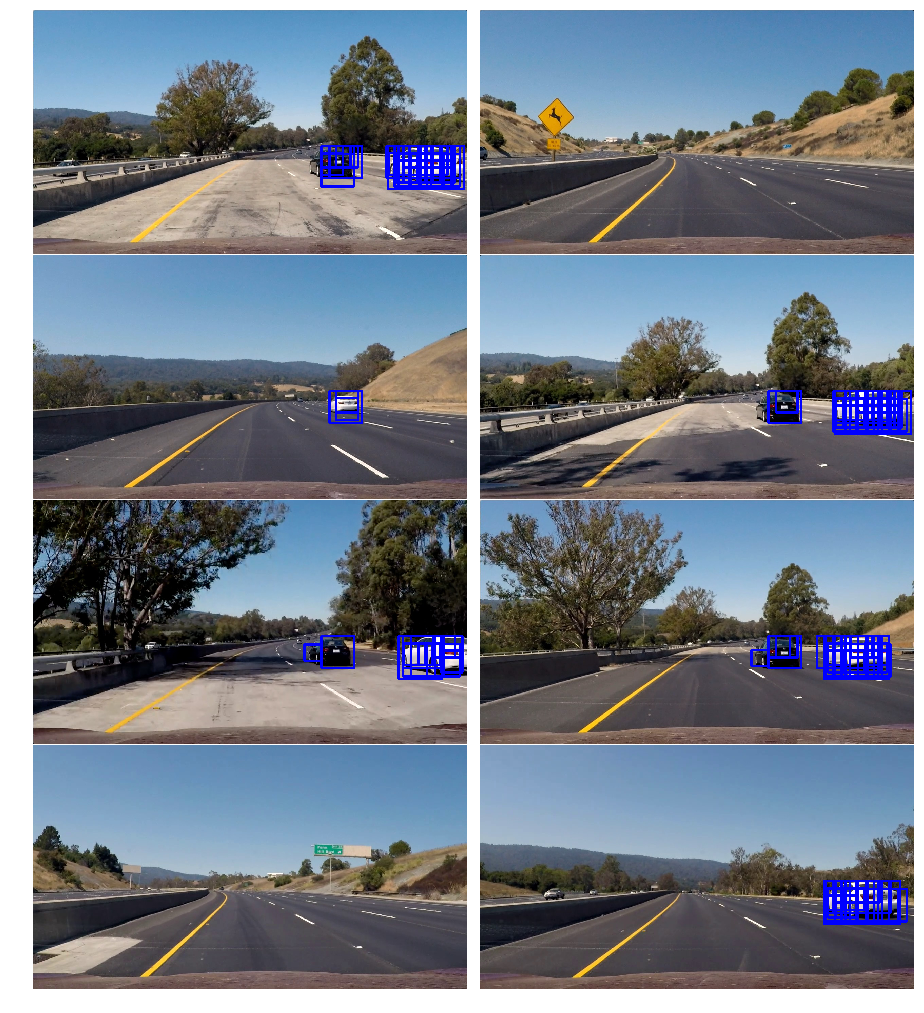

In [39]:
# Min and max in y to search in slide_window()
ystart = 400
ystop = 656 # => 400 + 4*8*8 = 400 + 256 = 656
scale = 0.9

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

svc = training_storage_01[color_space]['svc']
X_scaler = training_storage_01[color_space]['scaler']

hot_windows = {}
img_test_list = glob.glob('test_images/test*.jpg')

t=time.time() # Start time

fig, axs = plt.subplots(4, 2, figsize=(16,18))
fig.subplots_adjust(hspace = .004, wspace=.004)
axs = axs.ravel()

for i, image_p in enumerate(img_test_list):
    image = cv2.imread(image_p)
    draw_image = read_img(image_p)
    windows = all_sliding_windows(image)
    hot_windows[image_p]= (search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))   
    window_img = draw_boxes(draw_image, hot_windows[image_p], color=(0, 0, 255), thick=6)                    
    
    axs[i].imshow(window_img)
    axs[i].axis('off')
print(round(time.time()-t, 2), 'Seconds to process test images')

### Combine Various Sliding Window Searches

In [40]:
# ## all_y_start_stop = [[400, 448], [400, 464], [400, 496], [400, 560], [400, 544], [400, 656], [400, 688]]
# # all_wh = [24, 32, 48, 64, 96, 128, 144]
# # all_y_start_stop = [[400, 472], [400, 496], [400, 544], [400, 656]]
# # all_wh = [24, 48, 96, 128]
# # print(len(all_y_start_stop), ':', all_y_start_stop)
# # print(len(all_wh), ':',all_wh)
# scale_list = [0.375, 0.75, 1.0, 1.5, 2.0]
# print(len(scale_list), ':', scale_list)

# idx = 4
# image = read_img(test_images[idx])
# draw_image = np.copy(image)
# hot_windows = all_sliding_windows(image, ystart, ystop, scale_list, svc, X_scaler, orient, pix_per_cell, 
#                         cell_per_block, spatial_size, hist_bins, color_space=color_space)                     

# window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
# fig = get_new_figure()
# plt.imshow(window_img)

### Heatmap
This method (duplicated from lesson material) produces a heat map based on rectangle locations (additive with overlap).

In [41]:
def add_heat(heatmap, bbox_list, margin=10):
    img = np.copy(heatmap)
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        img[box[0][1]-margin:box[1][1]+margin, box[0][0]-2*margin:box[1][0]+2*margin] += 1

    # Return updated heatmap
    return img

0.33 Seconds to process test images


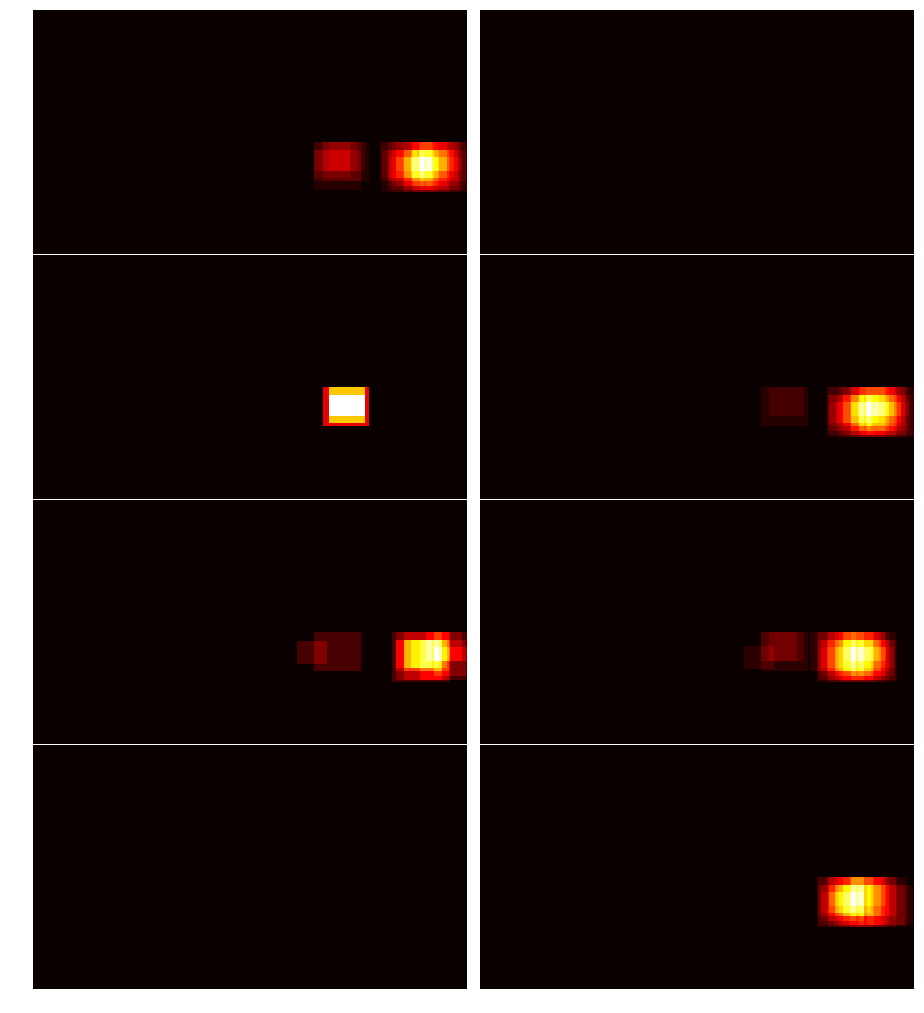

In [42]:
# heatmap_img = np.zeros_like(image[:,:,0])
# heatmap_img = add_heat(heatmap_img, hot_windows)
# plt.figure(figsize=(10,10))
# plt.imshow(heatmap_img, cmap='hot')

heatmap_img = {}
t=time.time() # Start time

fig, axs = plt.subplots(4, 2, figsize=(16,18))
fig.subplots_adjust(hspace = .004, wspace=.004)
axs = axs.ravel()

for i, image_p in enumerate(img_test_list):
    image = cv2.imread(image_p)
    heatmap_img0 = np.zeros_like(image[:,:,0])
    heatmap_img[image_p] = add_heat(heatmap_img0, hot_windows[image_p])                    
    
    axs[i].imshow(heatmap_img[image_p], cmap='hot')
    axs[i].axis('off')
print(round(time.time()-t, 2), 'Seconds to process test images')

### Apply a Threshold to the Heatmap

In [43]:
def apply_threshold(heatmap, threshold):
    img = np.copy(heatmap)
    # Zero out pixels below the threshold
    img[heatmap <= threshold] = 0
    # Return thresholded map
    return img

0.29 Seconds to process test images


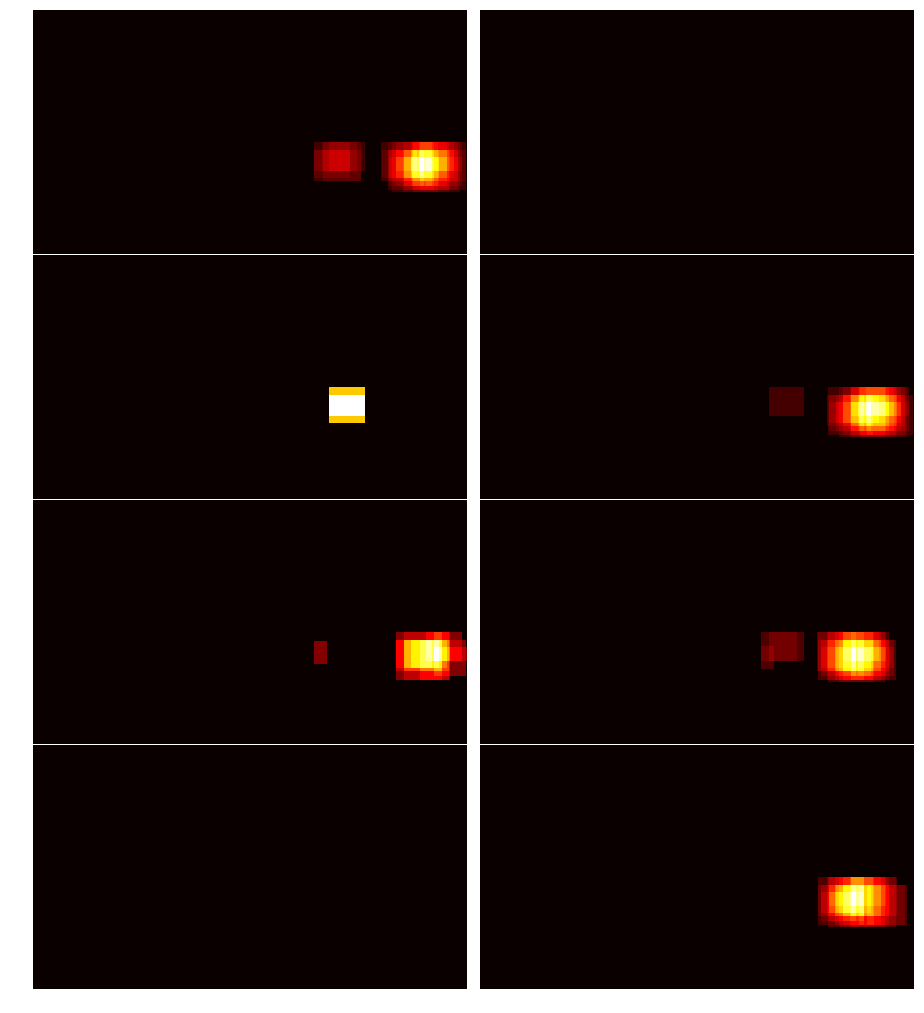

In [44]:
# heatmap_img2 = apply_threshold(heatmap_img, 2)
# plt.figure(figsize=(10,10))
# plt.imshow(heatmap_img2, cmap='hot')

heatmap_img_th = {}
t=time.time() # Start time
# for image_p in img_test_list:
#     heatmap_img2 = apply_threshold(heatmap_img[image_p], 2)
#     heatmap_img_th[image_p] = heatmap_img2
#     plt.figure(figsize=(8,5))
#     plt.imshow(heatmap_img2, cmap='hot')


fig, axs = plt.subplots(4, 2, figsize=(16,18))
fig.subplots_adjust(hspace = .004, wspace=.004)
axs = axs.ravel()

for i, image_p in enumerate(img_test_list):
    image = cv2.imread(image_p)
    heatmap_img2 = apply_threshold(heatmap_img[image_p], 1)
    heatmap_img_th[image_p] = heatmap_img2                 
    
    axs[i].imshow(heatmap_img2, cmap='hot')
    axs[i].axis('off')
print(round(time.time()-t, 2), 'Seconds to process test images')

### Apply SciPy Labels to Heatmap

In [51]:
def get_labels(img_th):
    labels = label(img_th)
    _map = labels[0]
    _count = labels[1]
    for i in range(1,_count+1):
        while(1):
            _num = np.count_nonzero(_map==i)
            if(_num > 0 and _num < 2000):
                a = np.zeros_like(_map)
                a[_map>i] = 1
                _map[_map==i] = 0
                _map=_map-a
                _count-=1
            else:
                # Find pixels with each car_number label value
                nonzero = (_map==i).nonzero()
                # Identify x and y values of those pixels
                nonzeroy = np.array(nonzero[0])
                nonzerox = np.array(nonzero[1])
                break
    return (_map, _count)

2 cars found
0 cars found
1 cars found
2 cars found
2 cars found
2 cars found
0 cars found
1 cars found
0.24 Seconds to process test images


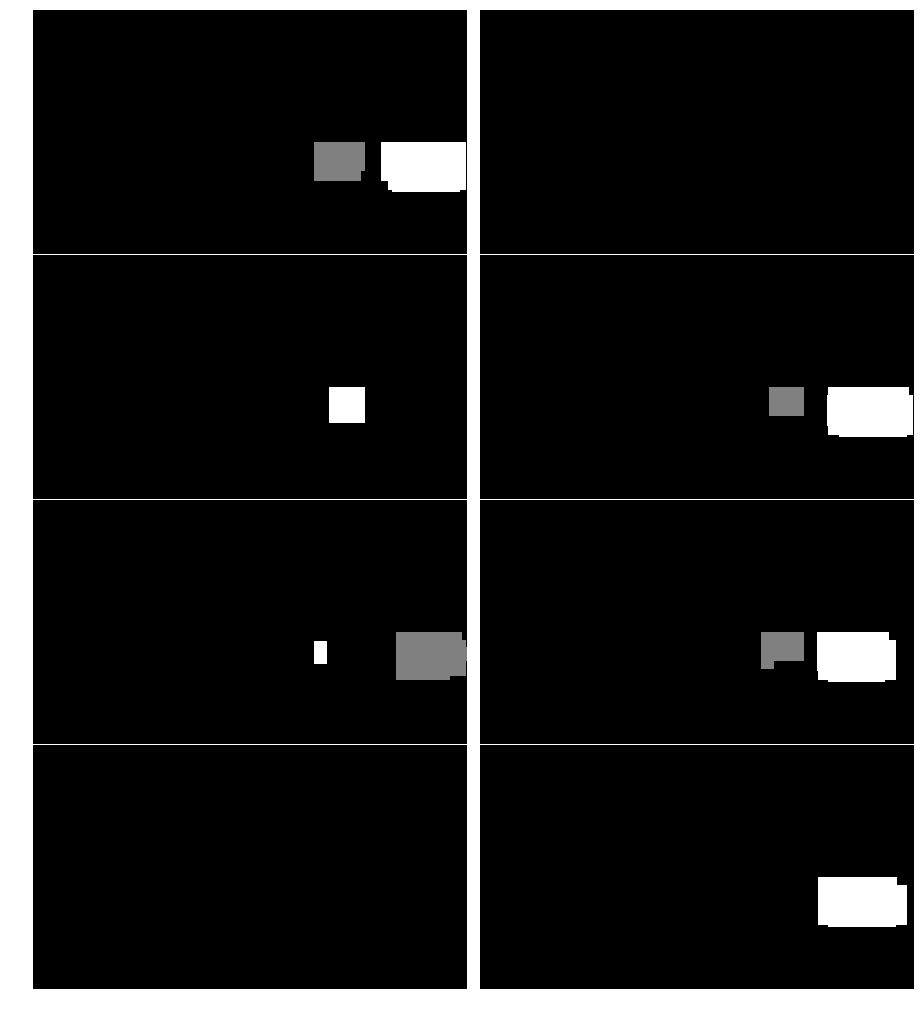

In [52]:
# labels = label(heatmap_img2)
# plt.figure(figsize=(8,5))
# plt.imshow(labels[0], cmap='gray')
# print(labels[1], 'cars found')

labels_list = {}
t=time.time() # Start time
# for image_p in img_test_list:
#     labels = get_labels(heatmap_img_th[image_p])
#     labels_list[image_p] = labels
#     plt.figure(figsize=(8,5))
#     plt.imshow(labels[0], cmap='gray')
#     print(labels[1], 'cars found')
    


fig, axs = plt.subplots(4, 2, figsize=(16,18))
fig.subplots_adjust(hspace = .004, wspace=.004)
axs = axs.ravel()

for i, image_p in enumerate(img_test_list):
    labels = get_labels(heatmap_img_th[image_p])
    labels_list[image_p] = labels                   
    
    print(labels[1], 'cars found')
    axs[i].imshow(labels[0], cmap='gray')
    axs[i].axis('off')
print(round(time.time()-t, 2), 'Seconds to process test images')


### Draw Bounding Boxes for Lables

In [53]:
def draw_labeled_bboxes(img, labels, draw=True):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        if(draw):
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

0.42 Seconds to process test images


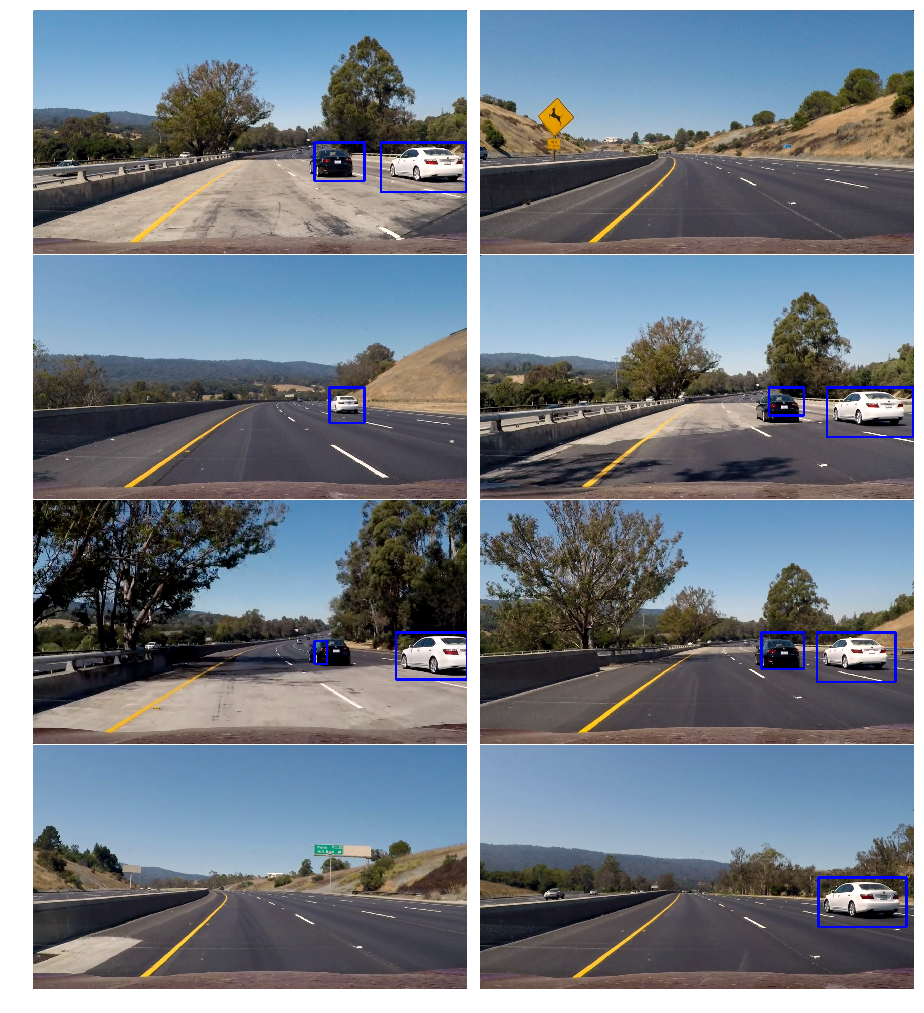

In [54]:
# # Draw bounding boxes on a copy of the image
# draw_img, rect = draw_labeled_bboxes(np.copy(image), labels)
# # Display the image
# plt.figure(figsize=(8,5))
# plt.imshow(draw_img)

t=time.time() # Start time
    
fig, axs = plt.subplots(4, 2, figsize=(16,18))
fig.subplots_adjust(hspace = .004, wspace=.004)
axs = axs.ravel()

rects = {}
for i, image_p in enumerate(img_test_list):
    image = read_img(image_p)
    labels = labels_list[image_p]                  
    # Draw bounding boxes on a copy of the image
    draw_img, rect = draw_labeled_bboxes(np.copy(image), labels)
    rects[image_p] = rect
    # Display the image
    axs[i].imshow(draw_img)
    axs[i].axis('off')
print(round(time.time()-t, 2), 'Seconds to process test images')


In [55]:
def get_fine_windows(image, rects, maxx, maxy, marginx = 80, marginy = 30):
    windows = []
    for rec in rects:
        x_start_stop=[rec[0][0]-marginx, min(rec[1][0]+marginx, maxx)]
        y_start_stop=[rec[0][1]-marginy, min(rec[1][1]+marginy, maxy)]
        windows += slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(128, 128), xy_overlap=(0.85, 0.85))

        windows += slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop,  
                            xy_window=(48, 48), xy_overlap=(0.85, 0.85))
    return windows


def fine_process_frame(img, img_bgr, windows):
    hot_windows = search_windows(img_bgr, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)    
    
    heatmap_img1 = np.zeros_like(img_bgr[:,:,0])
    heatmap_img1 = add_heat(heatmap_img1, hot_windows)
    heatmap_img1 = apply_threshold(heatmap_img1, 0)
    labels1 = get_labels(heatmap_img1)
    draw_img1, rects1 = draw_labeled_bboxes(np.copy(img), labels1)
    return draw_img1

11.95 Seconds to process test images


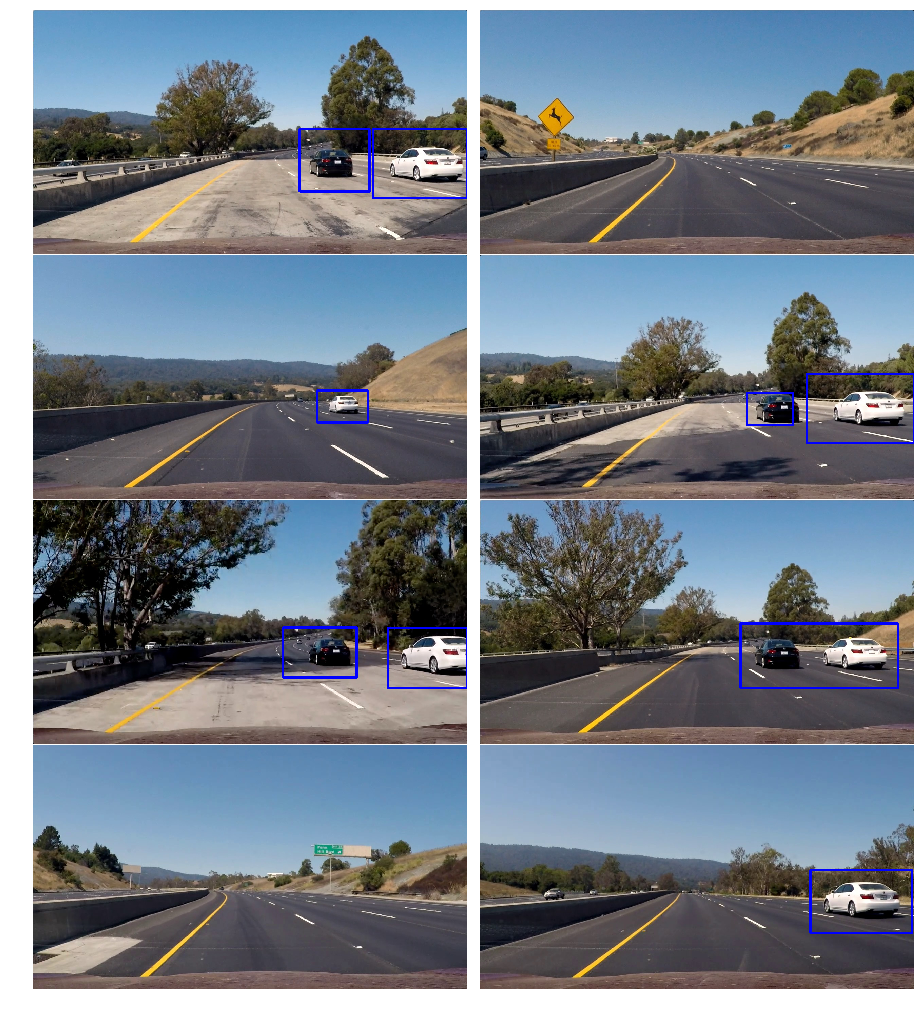

In [56]:
t=time.time() # Start time
    
fig, axs = plt.subplots(4, 2, figsize=(16,18))
fig.subplots_adjust(hspace = .004, wspace=.004)
axs = axs.ravel()

for i, image_p in enumerate(img_test_list):
    image = read_img(image_p)
    img_bgr = cv2.cvtColor(np.copy(image), cv2.COLOR_RGB2BGR)
    rect = rects[image_p]                  
    if(len(rect)>0):
        windows = get_fine_windows(image, rect, image.shape[1], image.shape[0])
        image = fine_process_frame(image,img_bgr, windows)
    axs[i].imshow(image)
    axs[i].axis('off')
print(round(time.time()-t, 2), 'Seconds to process test images')

In [57]:
def process_frame(img):
    img_bgr = cv2.cvtColor(np.copy(img), cv2.COLOR_RGB2BGR)
    windows = all_sliding_windows(img_bgr)
    
    hot_windows = search_windows(img_bgr, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)    
    
    heatmap_img1 = np.zeros_like(img_bgr[:,:,0])
    heatmap_img2 = add_heat(heatmap_img1, hot_windows)
    heatmap_img3 = apply_threshold(heatmap_img2, 0)
    labels1 = get_labels(heatmap_img3)
    img, rects1 = draw_labeled_bboxes(img, labels1, draw=True)                 
#     if(len(rects1)>0):
#         windows = get_fine_windows(img, rects1, img.shape[1], img.shape[0])
#         img = fine_process_frame(img, img_bgr, windows)
    return img


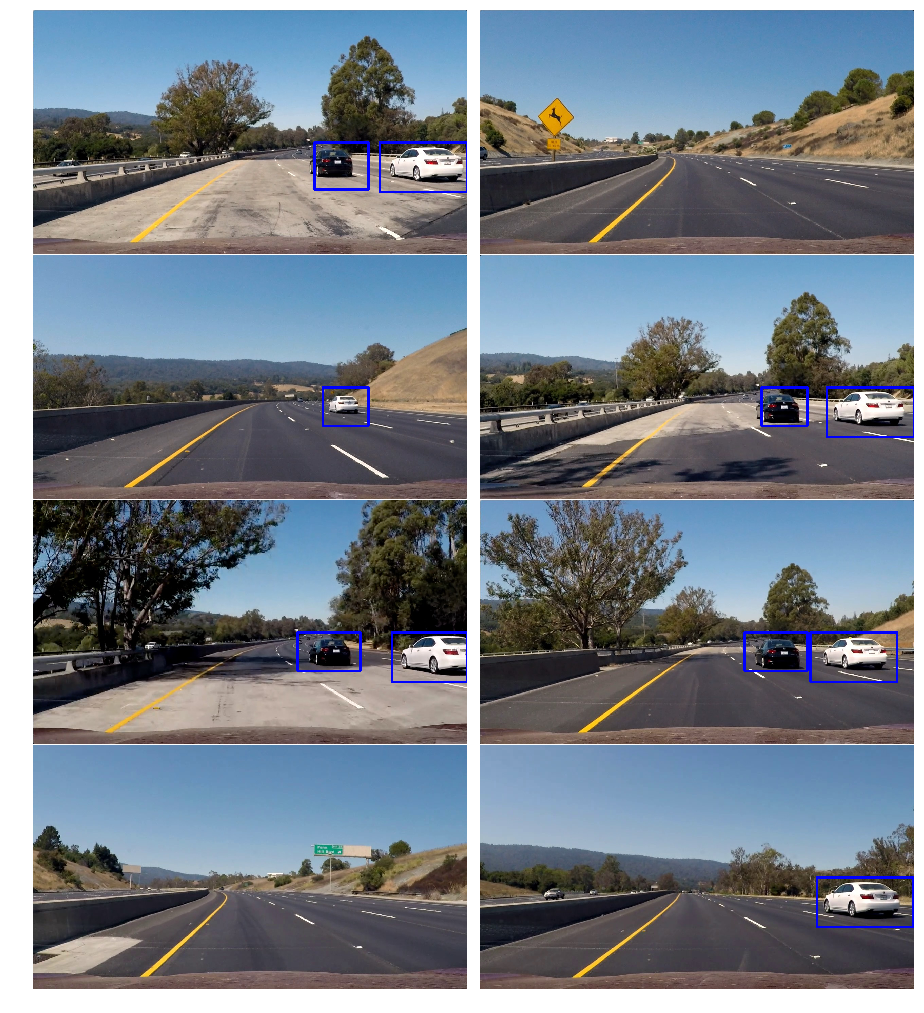

In [58]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(4, 2, figsize=(16,18))
fig.subplots_adjust(hspace = .004, wspace=.004)
axs = axs.ravel()

for i, im in enumerate(test_images):
    img = read_img(im)
    axs[i].imshow(process_frame(img))
    axs[i].axis('off')

### Make the Video
This only processes a frame at a time without accounting for information from previous frames

In [59]:
_output = 'output/project_video_YCrCb.mp4'
# white_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
# clip1 = VideoFileClip("test_videos/project_video.mp4").subclip(19,25)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(_output, audio=False)

[MoviePy] >>>> Building video output/project_video_YCrCb.mp4
[MoviePy] Writing video output/project_video_YCrCb.mp4


100%|█████████▉| 1260/1261 [06:27<00:00,  3.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/project_video_YCrCb.mp4 

Wall time: 6min 28s
